# loading the dependencies of tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import math

# INITIALIZE CONSTANT VARIABLES

In [3]:
IMAGE_SIZE=256

BATCH_SIZE = 32

CHANNELS = 3

EPOCHS = 50

# loading data using the keras from tensorflow:load classes and 

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Samples",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 110 files belonging to 2 classes.


In [5]:
classnames = dataset.class_names

In [6]:
print(classnames)

['Drought', 'Healthy Crop']


In [7]:
len(dataset)

4

# VISUALIZING THE IMAGES

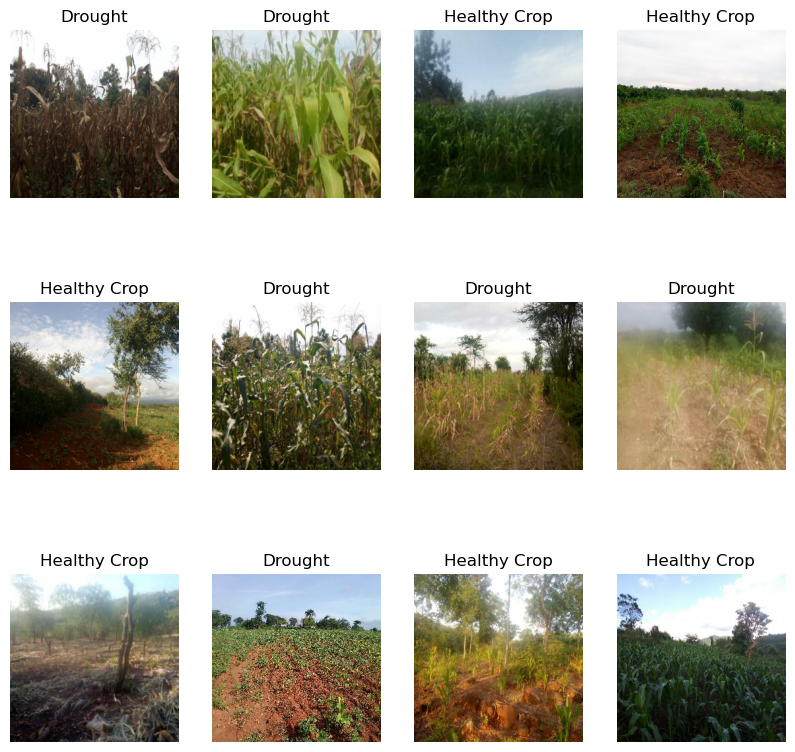

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classnames[label_batch[i]])
        plt.axis("off")

# creating a test for the model

In [18]:
# first we get the length of the dataset
dataset_length = len(dataset)

# 80% of the data would be used for training the model
#20% of the remaining data is split into validation and test of accuracy.(10% val and 10% test accuracy of the model)

In [19]:
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1

# TAKE SIZE FOR OUR MODEL TRAINING
TAKE_SIZE = dataset_length * TRAIN_SIZE
print(math.ceil(TAKE_SIZE))

4


In [20]:
train_dataset = dataset.take(54)
len(train_dataset)

4

In [21]:
# for test dataset, we will skip the first 54 of train dataset
tst_dataset = dataset.skip(54)
len(tst_dataset)

0

In [22]:
# VALIDATION DATASET SAMPLES NEEDED
len(dataset) * VALIDATION_SIZE

0.4

In [24]:
validation_dataset = tst_dataset.take(6)
len(validation_dataset)

0

In [25]:
# for the actual test dataset:
test_dataset = tst_dataset.skip(6);
len(test_dataset)

0

In [26]:
# shuffling the train dataset
#prefetch improves performance while shuffle randomely allocates the images in the dataset
#tensorflow here determines how many batches to load.
#the code is optimized to run fast
train_dataset= train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset= train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset= train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# TENSORFLOW DATA AUGMENTATION

# LAYERS FOR PREPROCESSING:

In [27]:
# preprocessing and scaling the data for better prerformance
resize_and_scale = tf.keras.Sequential([
#     prepocessing pipeline
    
    #resize the image to a size of 256 x 256
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    
    #scaling the image into binary of 0 and 1
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
#this process creates different 4 samples of the image for better prediction(horizantal flip,contrast,zoom,rotation)

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# BUILDING MODEL USING CONVULATIONAL NEURAL NETWORK(CNN)

In [30]:
INPUT_SHAPE = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

In [31]:
model = models.Sequential([
    #     first thing we resize and scale the image
    resize_and_scale,
    #perform data augmentation
    data_augmentation,
    layers.Conv2D(
        #(filters)trial: this is to annotate and accomodate the small edges of the image
        32,
        #filter size: (helps the Neural network figure)
        (3,3),
        #relu is fast to compute
        activation="relu",
        input_shape=INPUT_SHAPE,
    ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes, activation="softmax") #softmax normalizes the propability of the classes
])
model.build(input_shape=INPUT_SHAPE);

In [32]:
#displaying the summary of the model:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [33]:
# compile using optimizer
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_dataset,
)

Epoch 1/50
4/4 [==============================] - 18s 3s/step - loss: 1.0023 - accuracy: 0.4364 - val_loss: 0.7374 - val_accuracy: 0.4545
Epoch 2/50
4/4 [==============================] - 12s 3s/step - loss: 0.7306 - accuracy: 0.4818 - val_loss: 0.7357 - val_accuracy: 0.5455
Epoch 3/50
4/4 [==============================] - 13s 3s/step - loss: 0.7443 - accuracy: 0.4636 - val_loss: 0.6961 - val_accuracy: 0.5455
Epoch 4/50
4/4 [==============================] - 12s 3s/step - loss: 0.7253 - accuracy: 0.5364 - val_loss: 0.7024 - val_accuracy: 0.5455
Epoch 5/50
4/4 [==============================] - 11s 3s/step - loss: 0.7072 - accuracy: 0.5273 - val_loss: 0.6999 - val_accuracy: 0.5636
Epoch 6/50
4/4 [==============================] - 13s 3s/step - loss: 0.6999 - accuracy: 0.5364 - val_loss: 0.6957 - val_accuracy: 0.5455
Epoch 7/50
4/4 [==============================] - 10s 3s/step - loss: 0.6943 - accuracy: 0.5545 - val_loss: 0.6893 - val_accuracy: 0.5455
Epoch 8/50
4/4 [==================

In [35]:
#checking the score of the model
score = model.evaluate(test_dataset);

4/4 [==============================] - 3s 856ms/step - loss: 0.4605 - accuracy: 0.8000


In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 4}

In [38]:
#displaying accuracy, and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training And Validation Accuracy')

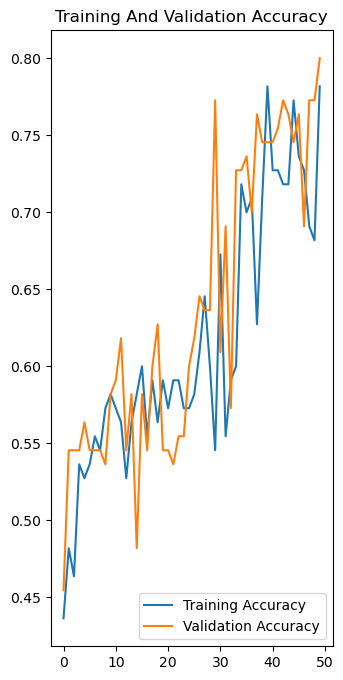

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy, label="Training Accuracy")
plt.plot(range(EPOCHS),val_accuracy,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training And Validation Accuracy")

Text(0.5, 1.0, 'Training And Validation Loss')

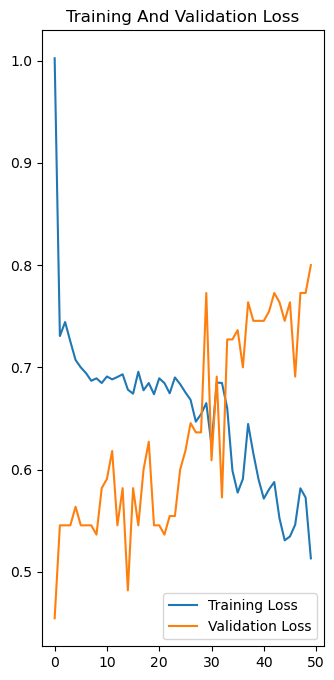

In [40]:
#loss
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss, label="Training Loss")
plt.plot(range(EPOCHS),val_accuracy,label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training And Validation Loss")

# making predictions

In [41]:
import numpy as np

FIRST IMAGE TO PREDICT
Actual label:  Healthy Crop
1/1 [==============================] - 1s 559ms/step
PREDICTED LABEL:  Healthy Crop
PREDICTION PERCENTAGE:  89.1


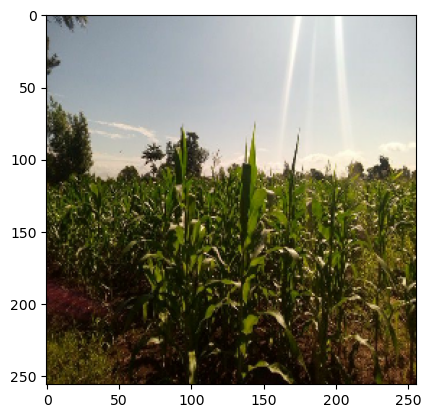

In [43]:
for image_batches,label_batches in test_dataset.take(1):
    first_image = image_batches[0].numpy().astype("uint8")
    first_label = label_batches[0].numpy()
    
    print("FIRST IMAGE TO PREDICT")
    plt.imshow(first_image)
    print("Actual label: ", classnames[first_label])
    
    batch_prediction = model.predict(image_batches)
    print("PREDICTED LABEL: ", classnames[np.argmax(batch_prediction[0])])
    prediction_score = round(100 * (np.max(batch_prediction[0])),2)
    print("PREDICTION PERCENTAGE: ", prediction_score)

In [56]:
model_version=1.1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1.1/assets


INFO:tensorflow:Assets written to: ../models/1.1/assets


In [58]:
import tensorflow as tf

# Example: Assuming 'model' is your TensorFlow model
model_version = "1.3"
save_path = f"../models/{model_version}"

# Save the model in the SavedModel format
# model.save(save_path, save_format='tf')

# Alternatively, save in HDF5 format
model.save(f"../models/{model_version}.h5", save_format='h5')


/Users/user/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# converting the model int tensorflow js